In [43]:
# Importing the libraries
import numpy as np
import pandas as pd

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, 
    AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [44]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [4]:
# define f0.5 score
from sklearn.metrics import fbeta_score, make_scorer
f05_score = make_scorer(fbeta_score, beta=0.5)

In [5]:
def evaluate_model(y_test, y_pred):
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    disp  = skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    disp.set_title("Confusion Matrix")
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0] 
    
    print('Classification Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
    print('Classification Error: %.3f' % (1 - metrics.accuracy_score(y_test, y_pred)))
    print('Sensitivity: %.3f' % metrics.recall_score(y_test, y_pred))
    print('Specificity: %.3f' % (TN / float(TN + FP)))
    print('False Positive Rate: %.3f' % (FP / float(TN + FP)))
    print('Precision: %.3f' % (TP / float(TP + FP)))
    print('F1 Score: %.3f' % metrics.f1_score(y_test, y_pred))
    print('AUC: %.3f' % metrics.roc_auc_score(y_test, y_pred))

In [65]:
def compareEnsembleAlgorithmsForBarChart(X_train, y_train):
    # Compare Algorithms
    import pandas
    from sklearn.model_selection import StratifiedKFold
  
    # prepare configuration for cross validation test harness
    seed = 7

    # prepare models
    models = []
    models.append(('BC', BaggingClassifier(DecisionTreeClassifier())))
    models.append(('RFC', RandomForestClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    


    # evaluate each model in turn
    
    names = []
    precision_results=[]
    recall_results=[]
    auc_results=[]
    f05_results=[]
    
    # make splits for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    
    for name, model in models:
        names.append(name)

        # calculate scores
            
        precision_cv_results = model_selection.cross_val_score(model, X_train,
                                                               y_train, cv=skf, scoring='precision')
        recall_cv_results = model_selection.cross_val_score(model, X_train,
                                                            y_train, cv=skf, scoring='recall')
        auc_cv_results = model_selection.cross_val_score(model, X_train,
                                                         y_train, cv=skf, scoring='roc_auc')
        f05_cv_results = model_selection.cross_val_score(model, X_train,
                                                         y_train, cv=skf, scoring=f05_score)

        precision_results.append(precision_cv_results.mean())
        #print(precision_results)    # for testing only
        recall_results.append(recall_cv_results.mean())
        #print(recall_results)    # for testing only
        auc_results.append(auc_cv_results.mean())
        #print(auc_results)    # for testing only
        f05_results.append(f05_cv_results.mean())
        #print(f05_results)    # for testing only
        
        
    return precision_results, recall_results, auc_results, f05_results, names

In [46]:
def barChart(results, score, string):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np


    labels = ['Bagging', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects = ax.bar(x , results, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(score)
    ax.set_title(score)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    # annotate bars
    ax.bar_label(ax.containers[0], label_type='edge', fmt='%.2f')
    #ax.legend()

    fig.tight_layout()

    # save plot
    fileName = string +'.png'
    print(fileName)
    plt.savefig('figures/ensembleLearning/' + fileName)
    
    plt.show()


In [47]:
def twoGroupsBarChart(results1, string1, results2, string2, score, name):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np


    labels = ['Bagging', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, results1, width, label=string1)
    rects2 = ax.bar(x + width/2, results2, width, label=string2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(score)
    ax.set_title(score)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper center")

    # annotate bars
    i=0
    for container in ax.containers:
        ax.bar_label(ax.containers[i], label_type='edge', fmt='%.2f')
        i=i+1
    
    fig.tight_layout()

    
    
    fileName = name +'.png'
    print(fileName)
    plt.savefig('figures/ensembleLearning/BiB_Vs_BiB-GDM/' + fileName)
    
    
    plt.show()

In [57]:
def plotPrecisionRecallCurves(X_train, X_test, y_train, y_test, title, filename):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import plot_precision_recall_curve
    import matplotlib.pyplot as plt
    
    # prepare models
    models = []
    models.append(('BC', BaggingClassifier(DecisionTreeClassifier())))
    models.append(('RFC', RandomForestClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    
    names = []
    
    fig, ax = plt.subplots()
    
    # fit each model in turn
    for name, model in models:
        names.append(name)
        model.fit(X_train,y_train)
        plot_precision_recall_curve(model, X_test, y_test, ax = plt.gca(), name = name)
        
        
    
    no_skill = len(y_test[y_test['0']==1]) / len(y_test)

    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    
    ax.legend(loc='upper right')
        
    plt.title(title)
    
    fig.tight_layout()
    
    # save plot
    fileName = filename +'.png'
    print(fileName)
    plt.savefig('figures/ensembleLearning/' + fileName)
    
    plt.show()

In [58]:
def plotROCCurves(X_train, X_test, y_train, y_test, title, filename):
    from sklearn.metrics import plot_roc_curve
    import matplotlib.pyplot as plt
    
    # prepare models
    models = []
    models.append(('BC', BaggingClassifier(DecisionTreeClassifier())))
    models.append(('RFC', RandomForestClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    
    names = []
    
    fig, ax = plt.subplots()
    
    # fit each model in turn
    for name, model in models:
        names.append(name)
        model.fit(X_train,y_train)
        plot_roc_curve(model, X_test, y_test, ax = plt.gca(), name = name)

        
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    
    ax.legend(loc='lower right')
    #plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    plt.title(title)
    
    fig.tight_layout()
    
    # save plot
    fileName = filename +'.png'
    print(fileName)
    plt.savefig('figures/ensembleLearning/' + fileName)
    
    plt.show()

# BiB Dataset

In [59]:
# make stratified folds for cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=False)

# make feature matrix and target matrix
X = pd.read_csv('BibFeaturesMatrix_Preprocessed_OHEColumnsNamed.csv')
y = pd.read_csv('BibDependentVariableLGAEncoded.csv')

# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [60]:
import warnings
#ignore warnings 
warnings.filterwarnings("ignore")

ensemble_precision-recall.png


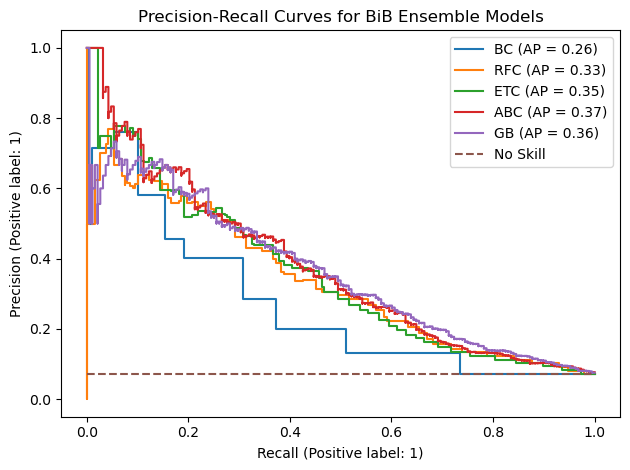

In [61]:
plotPrecisionRecallCurves(X_train, X_test, y_train, y_test, 
                          "Precision-Recall Curves for BiB Ensemble Models", "ensemble_precision-recall")

ensemble_roc.png


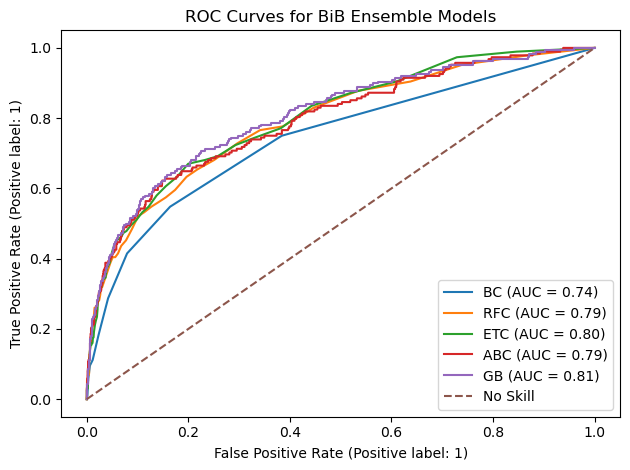

In [62]:
#plot ROC curves for all models
plotROCCurves(X_train, X_test, y_train, y_test,
                          "ROC Curves for BiB Ensemble Models", "ensemble_roc")

In [54]:
y.value_counts(normalize = True)*100

0
0    92.771827
1     7.228173
dtype: float64

In [66]:
precision_bib, recall_bib, auc_bib, f05_bib, names = compareEnsembleAlgorithmsForBarChart(X_train,y_train)

ensemble_precision_bib.png


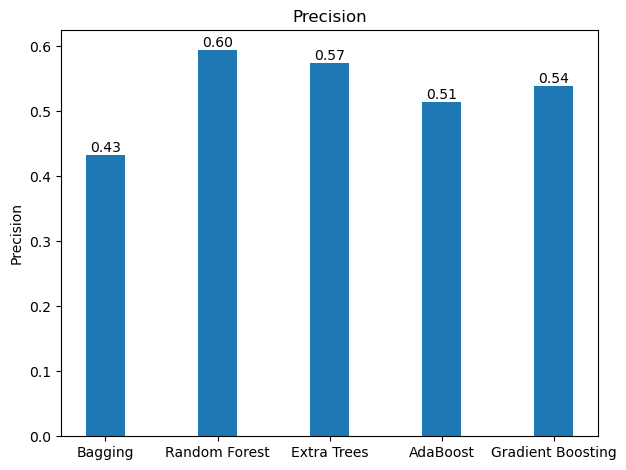

ensemble_recall_bib.png


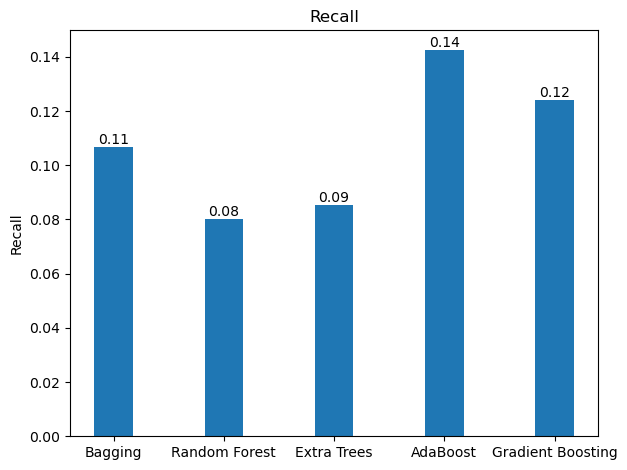

ensemble_auc_bib.png


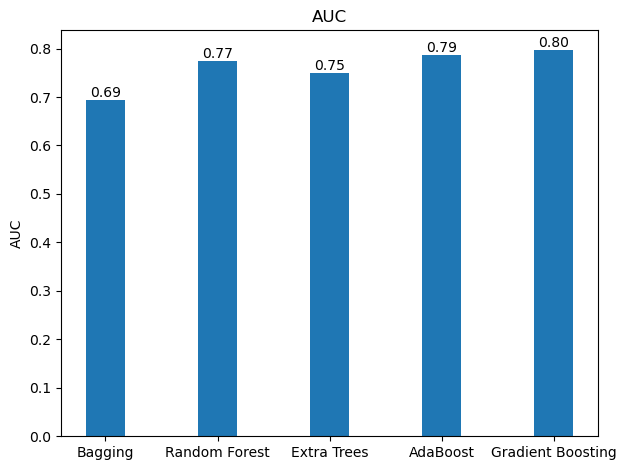

ensemble_f05_bib.png


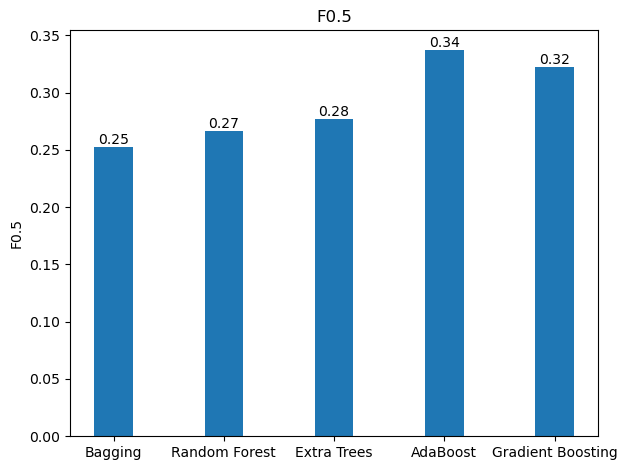

In [67]:
barChart(precision_bib, "Precision", "ensemble_precision_bib")
barChart(recall_bib, "Recall", "ensemble_recall_bib")
barChart(auc_bib, "AUC", "ensemble_auc_bib")
barChart(f05_bib, "F0.5", "ensemble_f05_bib")

# BiB-GDM Dataset

In [68]:
# make stratified folds for cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=False)

# make feature matrix and target matrix
X = pd.read_csv('BibGDMFeaturesMatrix_Preprocessed_OHEColumnsNamed.csv')
y = pd.read_csv('BibGDMDependentVariableLGAEncoded.csv')

# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

ensemble_precision-recall_bib-gdm.png


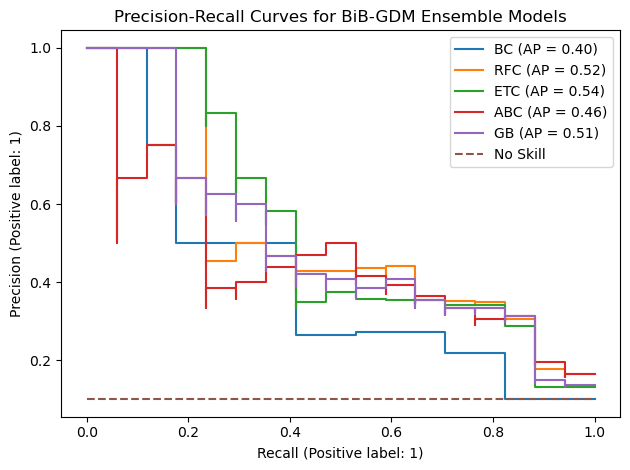

In [69]:
plotPrecisionRecallCurves(X_train, X_test, y_train, y_test, 
                          "Precision-Recall Curves for BiB-GDM Ensemble Models", "ensemble_precision-recall_bib-gdm")

ensemble_roc_bib-gdm.png


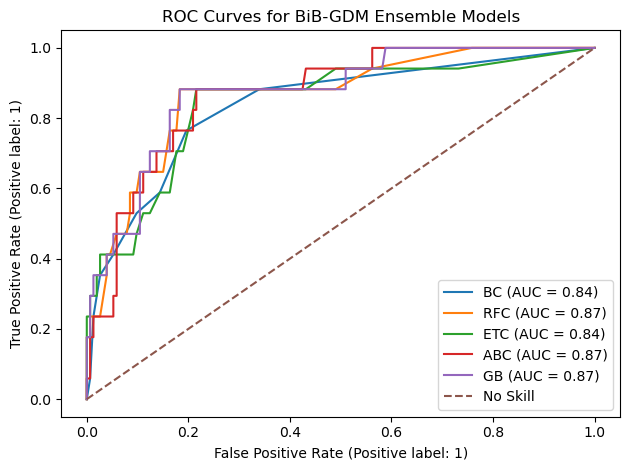

In [70]:
#plot ROC curves for all models
plotROCCurves(X_train, X_test, y_train, y_test,
                          "ROC Curves for BiB-GDM Ensemble Models", "ensemble_roc_bib-gdm")

In [71]:
precision_bib_gdm, recall_bib_gdm, auc_bib_gdm, f05_bib_gdm, names = compareEnsembleAlgorithmsForBarChart(X_train,y_train)

ensemble_precision_bib-gdm.png


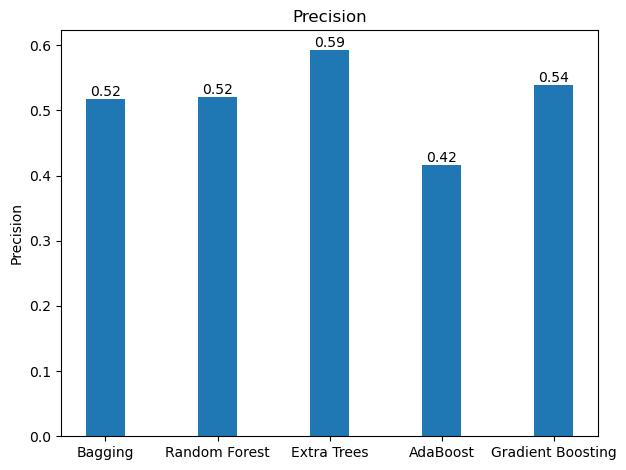

ensemble_recall_bib-gdm.png


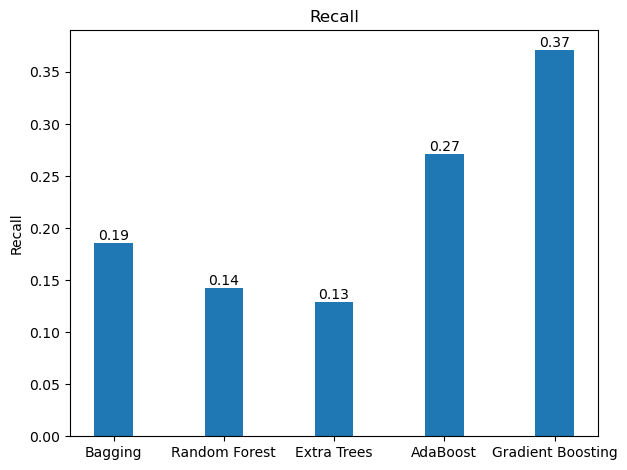

ensemble_auc_bib-gdm.png


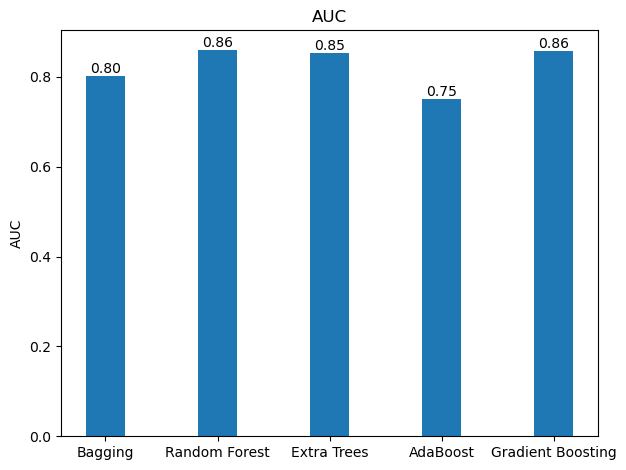

ensemble_f05_bib-gdm.png


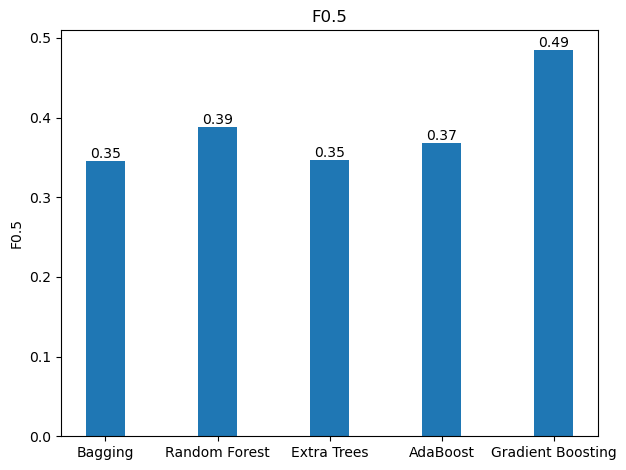

In [72]:
barChart(precision_bib_gdm, "Precision", "ensemble_precision_bib-gdm")
barChart(recall_bib_gdm, "Recall", "ensemble_recall_bib-gdm")
barChart(auc_bib_gdm, "AUC", "ensemble_auc_bib-gdm")
barChart(f05_bib_gdm, "F0.5", "ensemble_f05_bib-gdm")

# BiB vs BiB-GDM

bib_vs_bib-gdm_f05.png


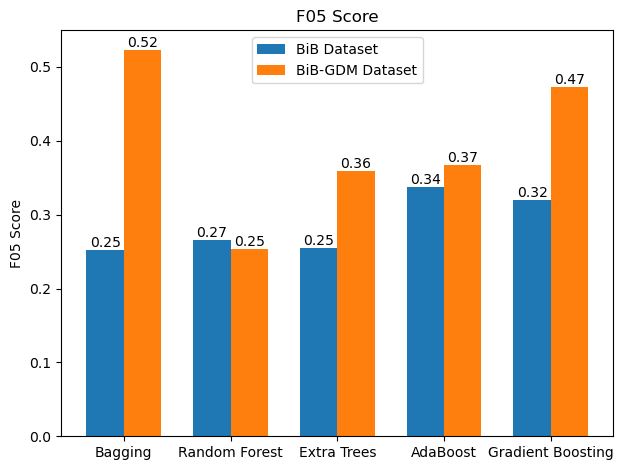

bib_vs_bib-gdm_recall.png


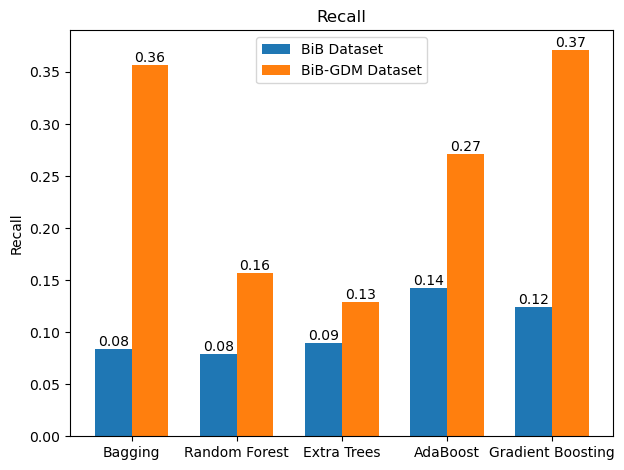

In [42]:
# plot BiB vs. BiB-GDM ensemble results

# twoGroupsBarChart(results1, string1, results2, string2, score, name):

twoGroupsBarChart(f05_bib, "BiB Dataset", f05_bib_gdm, "BiB-GDM Dataset", "F05 Score", "bib_vs_bib-gdm_f05")

twoGroupsBarChart(recall_bib, "BiB Dataset", recall_bib_gdm, "BiB-GDM Dataset", "Recall", "bib_vs_bib-gdm_recall")


bib_vs_bib-gdm_precision.png


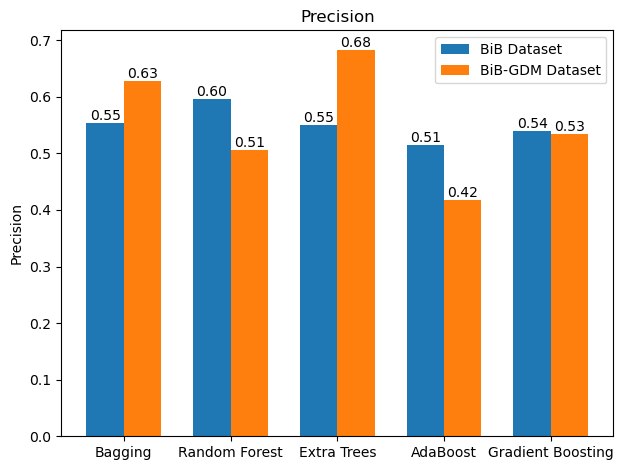

In [24]:
twoGroupsBarChart(precision_bib, "BiB Dataset", precision_bib_gdm, "BiB-GDM Dataset", "Precision", "bib_vs_bib-gdm_precision")
